In [1]:
# general modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time, glob
import json
import warnings

In [2]:
# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [3]:
# extras
from IPython.display import clear_output
from time import time
from time import sleep

In [4]:
# importing functions
from embedding import SimilarityEmbedding, VICRegLoss, train_one_epoch_se, val_one_epoch_se
from data_processing import Paper_data

In [5]:
# checking gpu status, ensures tensors are stored on the same device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


# Data Loading

In [6]:
# load in tensors

data_shifted_paper = torch.load('/nobackup/users/mmdesai/updated_tensors/data_shifted_paper4.pt')
data_unshifted_paper = torch.load('/nobackup/users/mmdesai/updated_tensors/data_unshifted_paper4.pt')
param_shifted_paper = torch.load('/nobackup/users/mmdesai/updated_tensors/param_shifted_paper4.pt')
param_unshifted_paper = torch.load('/nobackup/users/mmdesai/updated_tensors/param_unshifted_paper4.pt')

In [7]:
# define the dataset

num_batches_paper_sample = len(data_shifted_paper)
dataset_paper = Paper_data(data_shifted_paper, data_unshifted_paper, param_shifted_paper, param_unshifted_paper, num_batches_paper_sample)

In [8]:
# split dataset into training, testing, and validation

num_batches_paper_sample = len(data_shifted_paper)

train_set_size_paper = int(0.8 * num_batches_paper_sample)    
val_set_size_paper = int(0.1 * num_batches_paper_sample)     
test_set_size_paper = num_batches_paper_sample - train_set_size_paper - val_set_size_paper

train_data_paper, val_data_paper, test_data_paper = torch.utils.data.random_split(
    dataset_paper, [train_set_size_paper, val_set_size_paper, test_set_size_paper])

In [9]:
# load and shuffle the data

train_data_loader_paper = DataLoader(train_data_paper, batch_size=25, shuffle=True)
val_data_loader_paper = DataLoader(val_data_paper, batch_size=25, shuffle=True)
test_data_loader_paper = DataLoader(test_data_paper, batch_size=1, shuffle=False)

# Training

In [10]:
similarity_embedding = SimilarityEmbedding(num_dim=7, num_hidden_layers_f=1, num_hidden_layers_h=1, num_blocks=4, kernel_size=5, num_dim_final=2).to(device)
num_dim = 7

# optimizes
optimizer = optim.Adam(similarity_embedding.parameters(), lr=0.000004)

# define the loss
vicreg_loss = VICRegLoss()

# sets learning rate steps
scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5) #constant lr
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=2e-3) #one cycle - increase and then decrease
scheduler_3 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
scheduler = optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 15])

In [11]:
# print neural network parameters that require gradients and sum parameters

sum_param=0
for name, param in similarity_embedding.named_parameters():
    if param.requires_grad:
        # print(name)
        # print(param.numel())
        sum_param+=param.numel()
print('The total number of parameters for the embedding is: ' + str(sum_param))

The total number of parameters for the embedding is: 395051


In [12]:
# write to tensorboard

writer = SummaryWriter()
epoch_number = 0

In [13]:
%%time
# training the neural network for many epochs

epoch_number = 0
EPOCHS = 50

sim_val_loss = []
sim_train_loss = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    wt_repr, wt_cov, wt_std = (1, 1, 1)

    # Gradient tracking
    similarity_embedding.train(True)
    avg_train_loss = train_one_epoch_se(epoch_number, writer, train_data_loader_paper, similarity_embedding,
                                        optimizer, False, vicreg_loss,  
                                        wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_train_loss.append(avg_train_loss)
    
    # no gradient tracking, for validation
    similarity_embedding.train(False)
    similarity_embedding.eval()
    avg_val_loss = val_one_epoch_se(epoch_number, writer, val_data_loader_paper, 
                                    similarity_embedding, vicreg_loss,
                                    wt_repr=wt_repr, wt_cov=wt_cov, wt_std=wt_std)
    sim_val_loss.append(avg_val_loss)
    
    print(f"Train/Val Sim Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")

    epoch_number += 1
    scheduler.step()


EPOCH 1:
Train/Val Sim Loss after epoch: 0.8810/0.8689
EPOCH 2:
Train/Val Sim Loss after epoch: 0.6948/0.7536
EPOCH 3:
Train/Val Sim Loss after epoch: 0.4030/0.4572
EPOCH 4:
Train/Val Sim Loss after epoch: 0.1905/0.1940
EPOCH 5:
Train/Val Sim Loss after epoch: 0.1212/0.0623
EPOCH 6:


/home/mmdesai/.conda/envs/my_torch/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train/Val Sim Loss after epoch: 0.0743/0.0285
EPOCH 7:
Train/Val Sim Loss after epoch: 0.0493/0.0319
EPOCH 8:
Train/Val Sim Loss after epoch: 0.0855/0.0792
EPOCH 9:
Train/Val Sim Loss after epoch: 0.1137/0.2312
EPOCH 10:
Train/Val Sim Loss after epoch: 0.0424/0.0315
EPOCH 11:
Train/Val Sim Loss after epoch: 0.0381/0.0436
EPOCH 12:
Train/Val Sim Loss after epoch: 0.0285/0.0353
EPOCH 13:
Train/Val Sim Loss after epoch: 0.0185/0.0068
EPOCH 14:
Train/Val Sim Loss after epoch: 0.0176/0.0178
EPOCH 15:
Train/Val Sim Loss after epoch: 0.0214/0.0178
EPOCH 16:
Train/Val Sim Loss after epoch: 0.0353/0.0186
EPOCH 17:
Train/Val Sim Loss after epoch: 0.0189/0.0102
EPOCH 18:
Train/Val Sim Loss after epoch: 0.0208/0.0318
EPOCH 19:
Train/Val Sim Loss after epoch: 0.0170/0.0175
EPOCH 20:
Train/Val Sim Loss after epoch: 0.0146/0.0142
EPOCH 21:
Train/Val Sim Loss after epoch: 0.0148/0.0153
EPOCH 22:
Train/Val Sim Loss after epoch: 0.0158/0.0091
EPOCH 23:
Train/Val Sim Loss after epoch: 0.0270/0.0148
EPOCH

Text(0, 0.5, 'Loss')

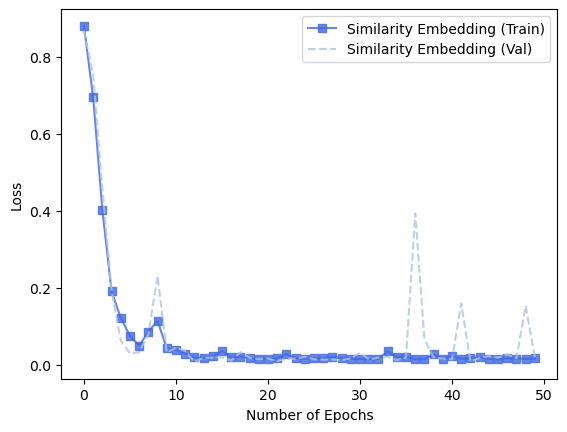

In [14]:
# plot the train/val loss 

epoch_list = range(0,len(sim_train_loss))
plt.plot(epoch_list, sim_train_loss, label = 'Similarity Embedding (Train)', color = 'royalblue', alpha = 0.8, marker = 's')
plt.plot(epoch_list, sim_val_loss, label = 'Similarity Embedding (Val)', color = 'lightsteelblue', alpha=0.8, linestyle="dashed")
plt.legend()
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')